In [32]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

import os
import pandas as pd
import numpy as np
import sys
from time import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import TimeDistributed
from keras.callbacks import TensorBoard
from keras.optimizers import RMSprop
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.utils import np_utils

from keras import backend as K
K.set_image_dim_ordering('tf')
import matplotlib.pyplot as plt
import itertools
from keras.regularizers import L1L2

import numpy as np
import pandas as pd
np.random.seed(10)

from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import Adagrad
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
from sklearn import manifold
import keras.layers.normalization as bn

from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import os        
from keras.utils import plot_model
import keras

from sklearn.preprocessing import normalize  
from sklearn.preprocessing import normalize  
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from keras import regularizers

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Convolution2D, UpSampling1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Dense
from keras.layers import Flatten, Dense, Reshape
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D, RepeatVector
from keras.models import Model
from data_util import *
from autoencoder import *

import pandas
import seaborn as sns

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0

In [33]:
path = "all_gene_input_data.csv"
type_features, type_labels = prepareData(path)

(7895, 20308)
(7895,)
Shauffle completed!


In [35]:
type_features = np.reshape(type_features,(type_features.shape[0], 1, type_features.shape[1]))

type_features = type_features.transpose(0,2,1)

print(type_features.shape)

# Shapes of training set
print("Feature set shape: {shape}".format(shape=type_features.shape))

# Shapes of test set
print("Label array shape: {shape}".format(shape=type_labels.shape))

(7895, 20308, 1)
Feature set shape: (7895, 20308, 1)
Label array shape: (7895,)


In [36]:
type_features.shape[0], type_features.shape[1], type_features.shape[2]

(7895, 20308, 1)

# The Convolutional Autoencoder!

In [37]:
input_layer = Input(shape=(20308, 1))
num_classes = 14

Let's create separate encoder and decoder functions since we will be using encoder weights later on for classification purpose!

In [38]:
autoencoder = Model(input_layer, decoder(encoder(input_layer)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop(lr=0.001))

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 20308, 1)          0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 20308, 32)         96        
_________________________________________________________________
batch_normalization_23 (Batc (None, 20308, 32)         128       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 20308, 32)         2080      
_________________________________________________________________
batch_normalization_24 (Batc (None, 20308, 32)         128       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 10154, 32)         0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 10154, 64)         4160      
__________

In [39]:
autoencoder_train = autoencoder.fit(type_features, type_features, batch_size=32, epochs=10, verbose=1, validation_split=0.1)

Train on 7105 samples, validate on 790 samples
Epoch 1/10
7105/7105 [==============================] - 710s 100ms/step - loss: 0.0344 - val_loss: 0.0164
Epoch 2/10
7105/7105 [==============================] - 589s 83ms/step - loss: 0.0109 - val_loss: 0.8146
Epoch 3/10
7105/7105 [==============================] - 588s 83ms/step - loss: 0.0105 - val_loss: 0.0115
Epoch 4/10
7105/7105 [==============================] - 588s 83ms/step - loss: 0.0105 - val_loss: 0.8014
Epoch 5/10
7105/7105 [==============================] - 588s 83ms/step - loss: 0.0123 - val_loss: 0.8256
Epoch 6/10
7105/7105 [==============================] - 588s 83ms/step - loss: 0.0137 - val_loss: 0.0116
Epoch 7/10
7105/7105 [==============================] - 588s 83ms/step - loss: 0.0103 - val_loss: 0.0110
Epoch 8/10
7105/7105 [==============================] - 588s 83ms/step - loss: 0.0103 - val_loss: 0.8292
Epoch 9/10
7105/7105 [==============================] - 588s 83ms/step - loss: 0.0103 - val_loss: 0.0102
Epoch 1

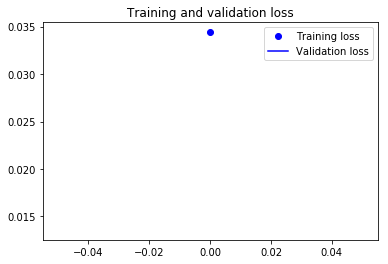

In [13]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Classification model

Let's define the fully connected layers that you will be stacking up with the encoder function.

In [15]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

encode = encoder(input_layer)
full_model = Model(input_layer, fc(encode))

#for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    #l1.set_weights(l2.get_weights())

Let's print first layer weights of both the models.

In [16]:
full_model.get_weights()[0][1]

array([[-0.00551033, -0.26436415,  0.18341604,  0.1884855 ,  0.14302844,
         0.05221254,  0.16581374,  0.11870492,  0.1683194 , -0.13274796,
        -0.15029387, -0.28066364, -0.18169379,  0.0646866 ,  0.02428335,
         0.18222883,  0.14874   , -0.04383919, -0.06510088, -0.28985518,
         0.19701856, -0.03284863,  0.09683183,  0.20184976, -0.1066173 ,
        -0.19589585,  0.16308719, -0.07178247,  0.1592477 ,  0.08996254,
         0.06768474,  0.13521144]], dtype=float32)

Voila! Both the arrays look exactly similar. So, without any further ado, let's compile the model and start the training. Next, you will make the encoder part i.e.the first nineteen layers of the model trainable false. Since the encoder part is already trained, you do not need to train it. You will only be training the Fully Connected part.

In [17]:
for layer in full_model.layers[0:19]:
    layer.trainable = True
    
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20308, 1)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 20308, 32)         96        
_________________________________________________________________
batch_normalization_12 (Batc (None, 20308, 32)         128       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 20308, 32)         2080      
_________________________________________________________________
batch_normalization_13 (Batc (None, 20308, 32)         128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 10154, 32)         0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 10154, 64)         4160      
__________

In [18]:
type_labels_one_hot = to_categorical(type_labels)

# Display the change for category label using one-hot encoding
print('Original label:', type_labels[0])
print('After conversion to one-hot:', type_labels_one_hot[0])
    
from sklearn.utils import class_weight
train_x, test_x, train_y, test_y = prepare_test_train_valid(type_features, type_labels_one_hot)

sample_weights = class_weight.compute_sample_weight('balanced', train_y)
print(train_x.shape)
train_x = train_x.transpose(0,2,1)
test_x = test_x.transpose(0,2,1)

print(train_x.shape)
print(test_y.shape)

Original label: 1
After conversion to one-hot: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
X_train shape: (5921, 20308, 1)
Y_train shape: (5921, 14)
(5921, 1, 20308)
(5921, 20308, 1)
(1974, 14)


# Train the Model

In [19]:
classify_train = full_model.fit(train_x, train_y, validation_split=0.1, batch_size=64, epochs=1, verbose=1)
full_model.save_weights('autoencoder_classification.h5')

Train on 5328 samples, validate on 593 samples
Epoch 1/1
5328/5328 [==============================] - 190s 36ms/step - loss: 10.9721 - acc: 0.3069 - val_loss: 11.5714 - val_acc: 0.2816


Next, you will re-train the model by making the first nineteen layers trainable as True instead of keeping them False! So, let's quickly do that.

In [20]:
for layer in full_model.layers[0:19]:
    layer.trainable = True
    
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.0001),metrics=['accuracy'])
classify_train = full_model.fit(train_x, train_y, batch_size=64,epochs=1,verbose=1,validation_split=0.1)

full_model.save_weights('classification_complete.h5')

Train on 5328 samples, validate on 593 samples
Epoch 1/1
5328/5328 [==============================] - 190s 36ms/step - loss: 10.8615 - acc: 0.3251 - val_loss: 10.4116 - val_acc: 0.3508


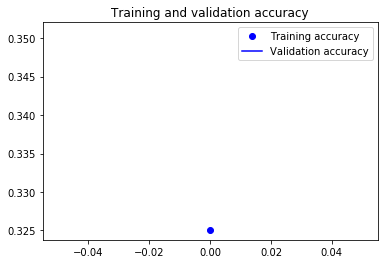

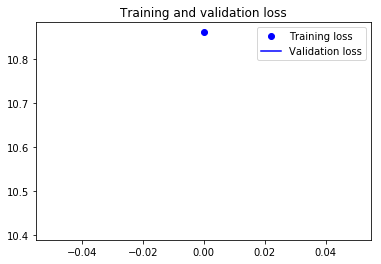

In [21]:
accuracy = classify_train.history['acc']
val_accuracy = classify_train.history['val_acc']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Model Evaluation on the Test Set

In [22]:
test_eval = full_model.evaluate(test_x, test_y, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 10.711199055085187
Test accuracy: 0.33434650468004995


In [23]:
predicted_classes = full_model.predict(test_x)

In [24]:
predicted_classes.shape, test_y.shape

((1974, 14), (1974, 14))

In [25]:
print(test_y[0])

print(predicted_classes[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 5.879842e-23 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00]


In [26]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_y, predicted_classes))

ValueError: Mix type of y not allowed, got types {'multilabel-indicator', 'continuous-multioutput'}

In [31]:
pred = np.argmax(np.round(predicted_classes),axis=1)
y = np.argmax(np.round(test_y),axis=1)

pred.shape, y.shape

((1974,), (1974,))

In [32]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y, pred))

             precision    recall  f1-score   support

          0       0.82      0.41      0.55       122
          1       1.00      0.01      0.01       138
          2       1.00      0.01      0.03       137
          3       0.00      0.00      0.00       124
          4       0.00      0.00      0.00       139
          5       1.00      0.01      0.03       141
          6       0.06      0.79      0.12       134
          7       0.00      0.00      0.00       132
          8       0.69      0.39      0.50       283
          9       0.00      0.00      0.00       134
         10       0.00      0.00      0.00       144
         11       0.00      0.00      0.00       128
         12       0.00      0.00      0.00       104
         13       0.06      0.03      0.04       114

avg / total       0.37      0.14      0.12      1974



c:\users\admin-karim\appdata\local\programs\python\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
